# Predict the amount of renewable energy based on weather data

Datasources:

- [Load, wind and solar, prices in hourly resolution](https://data.open-power-system-data.org/time_series/2020-10-06)
- [Hourly geographically aggregated weather data for Europe](https://data.open-power-system-data.org/weather_data/2020-09-16)

In [1]:
# Download required datasets.
# There are two datasets: Energy-Timeseries and Weather-Timeseries
import pathlib

from urllib import request

DATA_DIR = pathlib.Path().parent.joinpath('data/')
ENERGY_DATA_DOWNLOAD_URL = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series.sqlite'
ENERGY_DATA_DB_PATH = DATA_DIR.joinpath('energy_time_series.sqlite')

WEATHER_DATA_DOWNLOAD_URL = 'https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.sqlite'
WEATHER_DATA_DB_PATH = DATA_DIR.joinpath('weather_data.sqlite')

def download_data():
    download_weather_data()
    download_energy_data()    

def download_weather_data():
    if WEATHER_DATA_DB_PATH.exists() and WEATHER_DATA_DB_PATH.is_file():
        # The data does already exist.
        # Nothing to do..
        return None
    DATA_DIR.mkdir(exist_ok=True)
    request.urlretrieve(WEATHER_DATA_DOWNLOAD_URL, WEATHER_DATA_DB_PATH)
    return None

def download_energy_data():
    if ENERGY_DATA_DB_PATH.exists() and ENERGY_DATA_DB_PATH.is_file():
        # The data does already exist.
        # Nothing to do..
        return None
    DATA_DIR.mkdir(exist_ok=True)
    request.urlretrieve(ENERGY_DATA_DOWNLOAD_URL, ENERGY_DATA_DB_PATH)
    return None


In [2]:
download_data()

## Pepare the data

It is required to create a validation dataset. This dataset needs to be separated from the training data set to prevent overfitting. Therefore, I split the data by its date:

- **training data**: all data before 2019
- **validation data**: all data after 2019

In [3]:
import sqlite3
import pandas as pd

def read_data(db_path, query):
    db_connection = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, db_connection)
    db_connection.close()
    return df

def read_energy_data():
    cols_of_interest = ['utc_timestamp', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_wind_capacity', 'DE_wind_generation_actual']
    query = f"SELECT {','.join(cols_of_interest)} FROM time_series_60min_singleindex"
    df = read_data(ENERGY_DATA_DB_PATH, query)
    
    # Manually convert utc_timestamp to datetime with the correct format
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], format='ISO8601')
    
    return df

def get_energy_datasets():
    # Read raw data
    df = read_energy_data()
    
    # Split data based on the timestamp criteria
    training_df = df[df['utc_timestamp'] < '2019-01-01']
    validation_df = df[df['utc_timestamp'] >= '2019-01-01']
    
    training_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)
    
    return training_df, validation_df

def reat_weather_data():
    cols_of_interest = ['utc_timestamp', 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']
    query = f"SELECT {','.join(cols_of_interest)} FROM weather_Data"
    
    df = read_data(WEATHER_DATA_DB_PATH, query)
    
    # Manually convert utc_timestamp to datetime with the correct format
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], format='ISO8601')
    
    return df[df['utc_timestamp'] >= '2015-01-01']

def get_weather_datasets():
    # Read raw data
    df = reat_weather_data()
    
    # Split data based on the timestamp criteria
    training_df = df[df['utc_timestamp'] < '2019-01-01']
    validation_df = df[df['utc_timestamp'] >= '2019-01-01']
    
    training_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)
    
    return training_df, validation_df

In [4]:
energy_training_df, energy_validation_df = get_energy_datasets()
weather_training_df, weather_validation_df = get_weather_datasets()

## Discover and Visualize to gain insights


In [5]:
energy_training_df.info()
energy_validation_df.info()
energy_training_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35065 entries, 0 to 35064
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   utc_timestamp               35065 non-null  datetime64[ns, UTC]
 1   DE_solar_capacity           35065 non-null  float64            
 2   DE_solar_generation_actual  34961 non-null  float64            
 3   DE_wind_capacity            35065 non-null  float64            
 4   DE_wind_generation_actual   34990 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 1.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15336 entries, 0 to 15335
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   utc_timestamp               15336 non-null  datetime64[ns, UTC]
 1   DE_solar_capacity        

,DE_solar_capacity,DE_solar_generation_actual,DE_wind_capacity,DE_wind_generation_actual
count,35065.000000,34961.000000,35065.000000,34990.000000
mean,40592.386026,4184.239495,37577.267646,10412.722921
std,2652.494781,6415.452703,6088.210852,8189.076184
min,37248.000000,0.000000,27913.000000,135.000000
25%,38631.000000,0.000000,32812.000000,4081.000000
50%,40085.000000,124.000000,37145.000000,8072.500000
75%,41717.000000,6625.000000,42863.000000,14676.000000
max,47480.000000,28955.000000,48974.000000,44629.000000


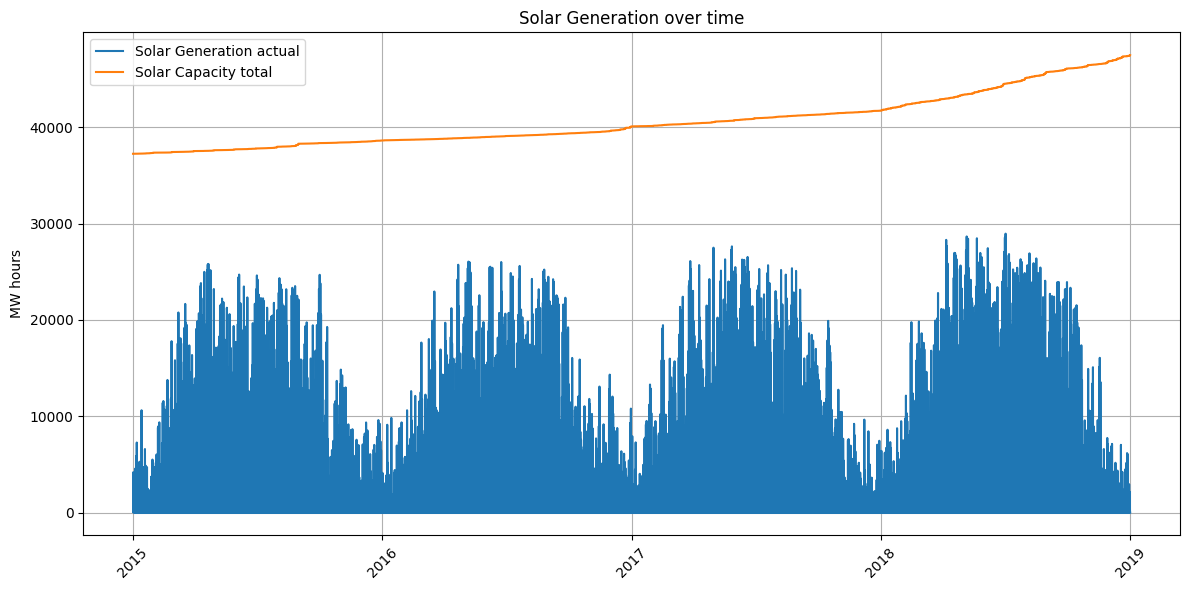

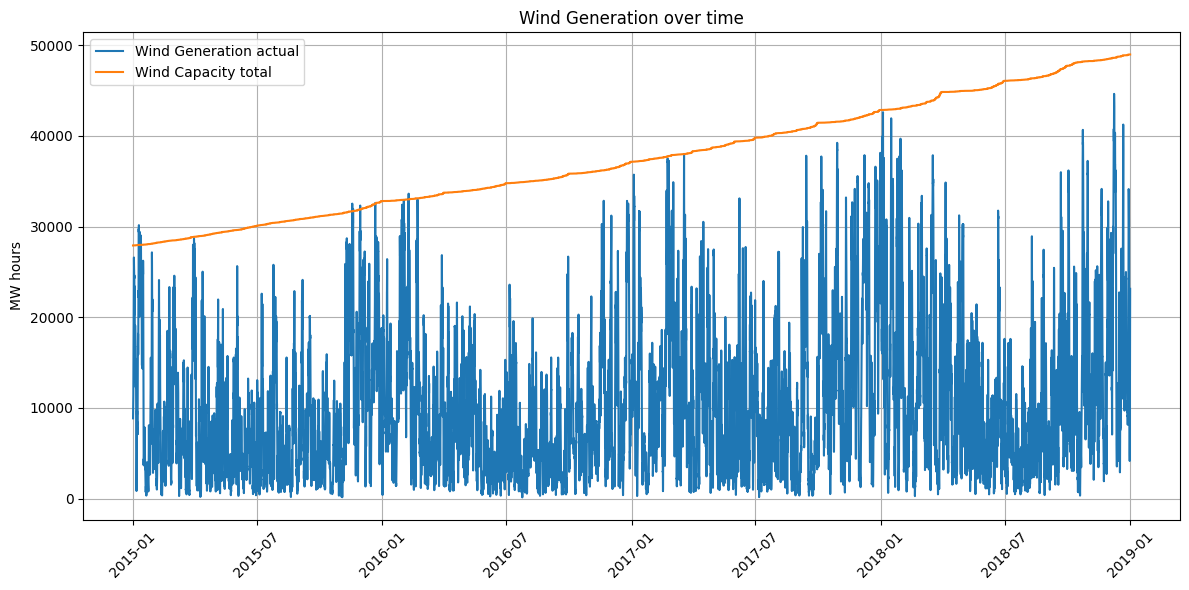

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Create a date formatter for the x-axis
date_formatter = mdates.DateFormatter('%Y')
locator = mdates.YearLocator()

ax = plt.gca()
ax.xaxis.set_major_formatter(date_formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis

df = energy_training_df

plt.title('Solar Generation over time')
plt.plot(df['utc_timestamp'], df['DE_solar_generation_actual'], label='Solar Generation actual')
plt.plot(df['utc_timestamp'], df['DE_solar_capacity'], label='Solar Capacity total')
plt.ylabel('MW hours')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))

plt.title('Wind Generation over time')
plt.plot(df['utc_timestamp'], df['DE_wind_generation_actual'], label='Wind Generation actual')
plt.plot(df['utc_timestamp'], df['DE_wind_capacity'], label='Wind Capacity total')
plt.ylabel('MW hours')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.legend()
plt.show()



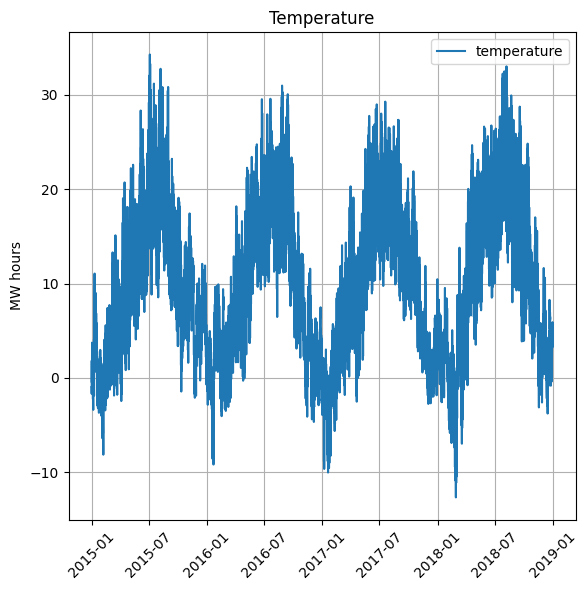

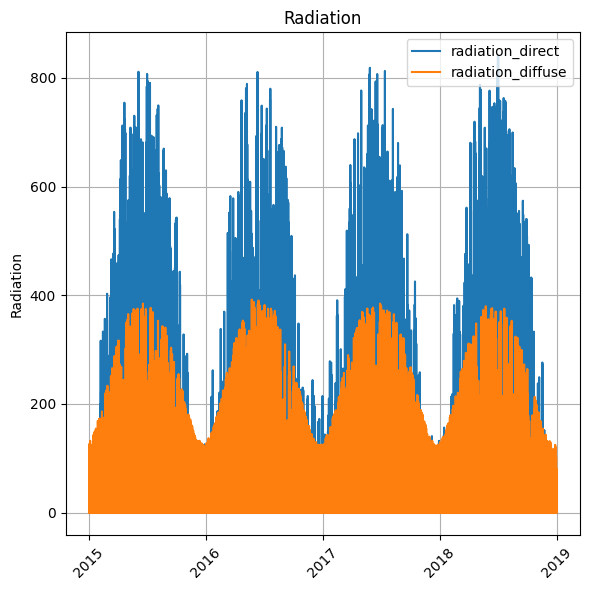

In [7]:
plt.figure(figsize=(6, 6))

df = weather_training_df

plt.title('Temperature')
plt.plot(df['utc_timestamp'], df['DE_temperature'], label='temperature')
plt.ylabel('MW hours')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))

ax = plt.gca()
ax.xaxis.set_major_formatter(date_formatter)
ax.xaxis.set_major_locator(locator)

plt.title('Radiation')
plt.plot(df['utc_timestamp'], df['DE_radiation_direct_horizontal'], label='radiation_direct')
plt.plot(df['utc_timestamp'], df['DE_radiation_diffuse_horizontal'], label='radiation_diffuse')
plt.ylabel('Radiation')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.legend()
plt.show()


## Correlations

In [8]:
merged_df = pd.merge(energy_training_df, weather_training_df, on='utc_timestamp', how='outer')

In [9]:
corr_matrix = merged_df.corr()
corr_matrix["DE_solar_generation_actual"].sort_values(ascending=False)

DE_solar_generation_actual         1.000000
DE_radiation_direct_horizontal     0.927490
DE_radiation_diffuse_horizontal    0.756710
DE_temperature                     0.558335
utc_timestamp                      0.029458
DE_wind_capacity                   0.029143
DE_solar_capacity                  0.027033
DE_wind_generation_actual         -0.177195
Name: DE_solar_generation_actual, dtype: float64

**Observations**:

- there is a strong positive correlation between solar generation and radiation (0.92 and 0.75)
- there is a positive correlation (but not as strong) between solar generation and temperate
- there is a marginal negative correlation between solar generation and wind generation

This means:

- if the sun shines, more solar power is generated
- if it is windy, it is generally a bit less sunny

Obviously...

In [10]:
corr_matrix["DE_wind_generation_actual"].sort_values(ascending=False)

DE_wind_generation_actual          1.000000
DE_wind_capacity                   0.199780
utc_timestamp                      0.194999
DE_solar_capacity                  0.186375
DE_radiation_diffuse_horizontal   -0.110208
DE_solar_generation_actual        -0.177195
DE_radiation_direct_horizontal    -0.191261
DE_temperature                    -0.237348
Name: DE_wind_generation_actual, dtype: float64

Observations:

- there is a a negative correlation between temperature, radiation and solar generation

This means that more wind power is generated if the weather is bad....

## Prepare the data

Some timestamps miss data for solar generation. These rows need to be removed from the label dataframe as well as from the training dataframe.

In [11]:
# Separate the labels into a single dataframe
solar_generation_labels = energy_training_df[['utc_timestamp', 'DE_solar_generation_actual']].copy()

# Drop all labels with missing data
solar_generation_labels = solar_generation_labels.dropna()

# Remove all rows from the training data that have no matching label
weather_training_df = weather_training_df[weather_training_df['utc_timestamp'].isin(solar_generation_labels['utc_timestamp'])]

# Their dimensions should be equal
total_rows_labels = solar_generation_labels.shape[0]
total_rows_predictors = weather_training_df.shape[0]
assert total_rows_labels == total_rows_predictors

# Scale the numerical values.
# Timestamps are numerical values and need to be dropped.
weather_data = weather_training_df.drop('utc_timestamp', axis=1)
solar_labels = solar_generation_labels.drop('utc_timestamp', axis=1)


# Scaling

Most Machine Learning algorithms don't perform well when the input numerical attributes have very different scales. In this case **radiation** values range from 0 to 800+, while the temperature values only range from -10 to 30. Therefore, **feature scaling** is required, to ensure that the input values have the same scale.

**NOTE**: The StandardScaler scales the data based on the statistics (mean and standard deviation) of your training dataset. When I apply this scaler to the test data, it uses the same statistics from the training data for scaling. This can lead to problems when the test data has a different distribution or range of values compared to the training data.

To address this issue, I have to fit the scalers to my training data raining data and then use the same scaler to transform both the training and test data.

<Axes: >

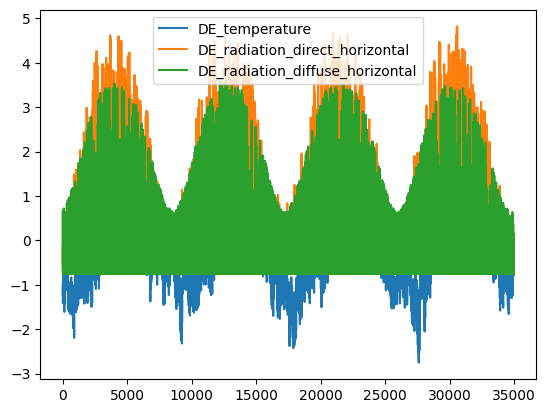

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numerical_attribs =  list(weather_data)

num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())
])

# Fit the pipeline to the training data
num_pipeline.fit(weather_data)

# Transform the values
weather_num_std_scaled = num_pipeline.transform(weather_data)

# The scaler returns a np.array, which needs to be converted back into a dataframe for pretty charts.
scaled_df = pd.DataFrame(data=weather_num_std_scaled, columns=weather_data.columns)
scaled_df.plot()

# Training

First, I will use a LinearRegression model to predict the solar generation.

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Use the scaled numerical values
solar_predictors = weather_num_std_scaled

# Actual model
lin_reg = LinearRegression()
lin_reg.fit(solar_predictors, solar_labels)

# Calculate the RMSE to check its accuracy
predictions = lin_reg.predict(solar_predictors)
lin_mse = mean_squared_error(solar_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


1415.1956378331417

A root mean square error of ~1415 is not too bad

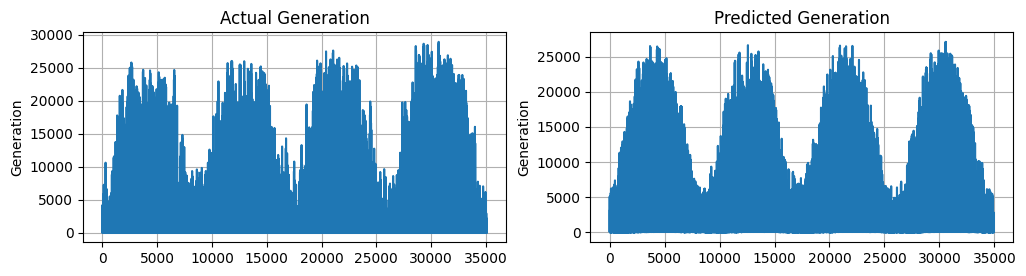

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title('Actual Generation')
plt.plot(solar_labels, label='actual')
plt.ylabel('Generation')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Predicted Generation')
plt.plot(predictions, label='prediction')
plt.ylabel('Generation')
plt.grid(True)



Ensure that the scaler fits well to smaller chunks of data:

In [15]:
some_data = weather_training_df.iloc[3720:3735]
some_data = some_data.drop('utc_timestamp', axis=1)
some_labels = solar_generation_labels.iloc[3720:3735]
some_prepared_data = num_pipeline.transform(some_data)

predictions = lin_reg.predict(some_prepared_data)
print('The model predicted:', predictions)
print('The acutal data:', some_labels)

The model predicted: [[10909.7611776 ]
 [14396.49312666]
 [17528.72239922]
 [19587.84076783]
 [20178.01127148]
 [19486.50116846]
 [17572.15241068]
 [14875.47609797]
 [11688.09122986]
 [ 8262.52975955]
 [ 4835.85027646]
 [ 1860.58241785]
 [  201.38392547]
 [   42.04044568]
 [   37.121722  ]]
The acutal data:                  utc_timestamp  DE_solar_generation_actual
3752 2015-06-06 07:00:00+00:00                     12059.0
3753 2015-06-06 08:00:00+00:00                     16087.0
3754 2015-06-06 09:00:00+00:00                     18933.0
3755 2015-06-06 10:00:00+00:00                     20442.0
3756 2015-06-06 11:00:00+00:00                     21342.0
3757 2015-06-06 12:00:00+00:00                     20630.0
3758 2015-06-06 13:00:00+00:00                     18735.0
3759 2015-06-06 14:00:00+00:00                     15779.0
3760 2015-06-06 15:00:00+00:00                     11466.0
3761 2015-06-06 16:00:00+00:00                      6803.0
3762 2015-06-06 17:00:00+00:00            